In [41]:
# Load protein-only trajectories

import MDAnalysis as mda
import MDAnalysis.analysis.atomicdistances as ad

base_dir = '/home/zach/Documents/md/ftsb-perm-zn-aMD/aMD defaults/ftsb-perm/openmm_amd_dual/'
base_dir = '../../trajectories/'

sample_dirs = ['first_run','second_run','third_run','fourth_run','fifth_run','sixth_run']

sample_dirs = ['ftsb-perm-1',
               'ftsb-perm-2',
               'ftsb-perm-replicate-1',
               'ftsb-perm-replicate-2',
               'ftsb-perm-low-boost-1',
               'ftsb-perm-low-boost-2']

pairs = [ ['segid PERM and resid 239 and name OH', 'segid FTSB and resid 191 and name NE1'],
         ['segid PERM and resid 40 and name OG1', 'segid FTSB and resid 187 and name OH'],
         ['segid PERM and resid 43 and name OE1', 'segid FTSB and resid 186 and name N'] ]

distances = []

for i in range(len(sample_dirs)):
    print(f'Loading sample {i}')
    u = mda.Universe(f'{base_dir}{sample_dirs[i]}/protein-only-initial-frame.pdb', f'{base_dir}{sample_dirs[i]}/protein-only.dcd')

    distances.append([])
    
    for j in range(len(pairs)):
    
        ag1 = u.select_atoms(pairs[j][0])
        ag2 = u.select_atoms(pairs[j][1])
        
        distances[-1].append(ad.AtomicDistances(ag1, ag2).run(step=1).results)

Loading sample 0


/Users/zach/miniconda3/envs/datascience/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/Users/zach/miniconda3/envs/datascience/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


Loading sample 1
Loading sample 2
Loading sample 3
Loading sample 4
Loading sample 5


In [32]:
import MDAnalysis.analysis.atomicdistances as ad

dt = 0.1 # ns

pairs = [ ['segid PERM and resid 239 and name OH', 'segid FTSB and resid 191 and name NE1'],
         ['segid PERM and resid 40 and name OG1', 'segid FTSB and resid 187 and name OH'],
         ['segid PERM and resid 43 and name OE1', 'segid FTSB and resid 186 and name N'] ]

distances = []


first_frame = 0
last_frame = 6499

for i in range(len(sample_dirs)):

    if i<2: # protein-only.dcd includes input PDB for first two simulations
        first_frame = 1
        last_frame = 6500
    else:
        first_frame = 0
        last_frame = 6499

    print('processing...',sample_dirs[i])
    u = mda.Universe(f'{base_dir}{sample_dirs[i]}/protein-only-initial-frame.pdb', f'{base_dir}{sample_dirs[i]}/protein-only.dcd')
    print(len(u.trajectory))
    distances.append([])
    
    for j in range(len(pairs)):
    
        ag1 = u.select_atoms(pairs[j][0])
        ag2 = u.select_atoms(pairs[j][1])
        
        distances[-1].append(ad.AtomicDistances(ag1[first_frame:last_frame], ag2[first_frame:last_frame]).run(step=1).results)

processing... ftsb-perm-1
11000
processing... ftsb-perm-2
11000
processing... ftsb-perm-replicate-1
6499
processing... ftsb-perm-replicate-2
6499
processing... ftsb-perm-low-boost-1
6499
processing... ftsb-perm-low-boost-2
6499


In [8]:
# Save text files with distances
import numpy as np
for i in range(6):
    for j in range(len(pairs)):
        p1 = pairs[j][0].split(' ')
        p2 = pairs[j][1].split(' ')
        fname = '_'.join(['650_ns_distances_run'+str(i+1),p1[1],p1[4],p1[7],p2[1],p2[4],p2[7]]) + '.dat'
        np.savetxt(fname, distances[i][j])

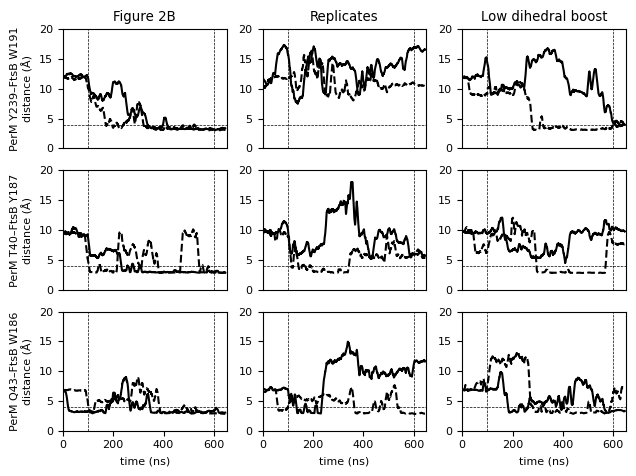

In [42]:
from matplotlib import pyplot as plt

plt.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'], 'size':8})

dt = 0.1
t = np.arange(len(distances[0][0][:6499]))*dt
N = int(10/dt) # window size

cs = ['k-','k--']

pairs = [ ['segid PERM and resid 239 and name OH', 'segid FTSB and resid 191 and name NE1'],
         ['segid PERM and resid 40 and name OG1', 'segid FTSB and resid 187 and name OH'],
         ['segid PERM and resid 43 and name OE1', 'segid FTSB and resid 186 and name N'] ]

bond_titles = ['PerM Y239–FtsB W191',
               'PerM T40–FtsB Y187',
               'PerM Q43–FtsB W186']

condition_titles = ['Figure 2B',
                    'Replicates',
                    'Low dihedral boost']

for i in range(len(distances)):

    if i<2:
        first_frame = 1
        last_frame = 6500
    else:
        first_frame = 0
        last_frame = 6499

    # i goes first, second, third, etc

    for j in range(len(distances[i])):
        # j is bond identity
        
        plt.subplot(3,3,3*j + i//2+1)

        y_smooth = np.convolve(distances[i][j][first_frame:last_frame,0], np.ones((N,))/N, mode='same')
        plt.plot(t[N//2:-(N-1-N//2)],y_smooth[N//2:-(N-1-N//2)],cs[i%2])
        plt.ylim([0,20])
        plt.xlim([0,650])

        if i%2:
            plt.axvline(100,color='black',linestyle='--',linewidth=0.5)
            plt.axvline(600,color='black',linestyle='--',linewidth=0.5)
            plt.axhline(4,color='black',linestyle='--',linewidth=0.5)

        if j==2:
            plt.xlabel('time (ns)')
        else:
            plt.xticks([])

        if i==0:
            plt.ylabel(bond_titles[j]+'\ndistance (Å)')

        if j==0:
            plt.title(condition_titles[i//2])

plt.tight_layout()

plt.savefig('650_ns_hbonds.svg')
plt.savefig('650_ns_hbonds.png')

In [43]:
# write PDBs for all-atom, last frame before 650 ns after wrapping trajectory

# Requires all-atom DCD files

from MDAnalysis import transformations as trans

for d in sample_dirs:

    print(d)
    
    u = mda.Universe(f'{base_dir}{d}/step5_input.psf', f'{base_dir}{d}/step8_aMD_postrun_10.dcd')
    protein = u.select_atoms('protein')
    not_protein = u.select_atoms('not protein')
    to_write = u.select_atoms('all')

    ftsb = u.select_atoms("segid PERM")
    ftsb.segments.segids = 'temp'
    perm = u.select_atoms("segid FTSB")
    perm.segments.segids = 'PERM'
    ftsb = u.select_atoms("segid temp")
    ftsb.segments.segids = 'FTSB'
    
    workflow = [trans.unwrap(protein), 
                trans.center_in_box(protein, wrap=False),
                # trans.wrap(not_protein,compound='fragments')
               ]
            
    u.trajectory.add_transformations(*workflow)

    to_write.write(f'{base_dir}{d}/{d}-650-ns-all-atom.pdb',frames=u.trajectory[[-1]])
    protein.write(f'{base_dir}{d}/{d}-650-ns-protein-only.pdb',frames=u.trajectory[[-1]])

/Users/zach/miniconda3/envs/datascience/lib/python3.12/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


ftsb-perm-1


OSError: DCD file does not exist

first_run


/home/zach/miniconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


second_run
third_run
fourth_run
fifth_run
sixth_run


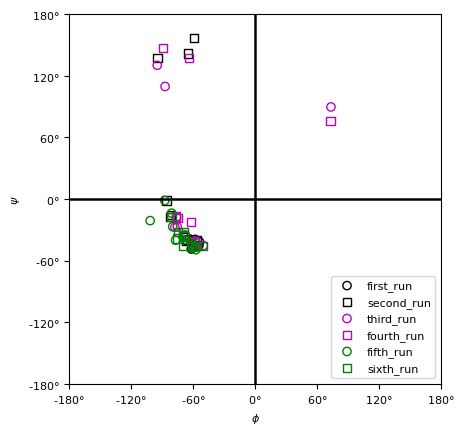

In [177]:
# Calculate angles for Ramachandran plot

import matplotlib.pyplot as plt
from MDAnalysis.analysis import dihedrals

cs = ['ko','ks','mo','ms','go','gs']

R = []

fig, ax = plt.subplots(figsize=plt.figaspect(1))

for i in range(6):

    d = sample_dirs[i]
    print(d)
    
    u = mda.Universe(f'{base_dir}{d}/step5_input.psf', f'{base_dir}{d}/step8_aMD_postrun_10.dcd')

    r = u.select_atoms("segid PERM and resid 186-194")
    R.append(dihedrals.Ramachandran(r).run(start=-1))

    R[-1].plot(ax=ax, facecolor='none', edgecolor=cs[i][0], marker=cs[i][1], label=d)

plt.legend(loc='lower right')
plt.show()

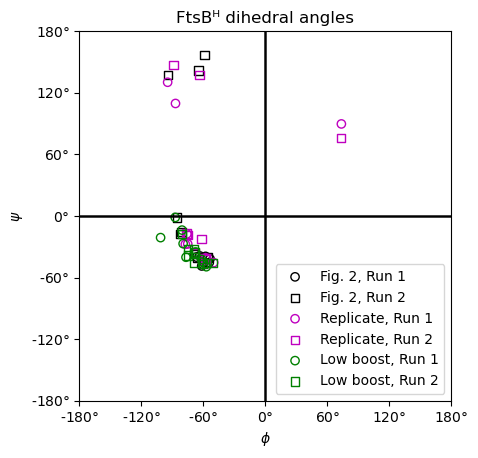

In [178]:
# plotting with labels for Fig S2

plt.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

fig, ax = plt.subplots(figsize=plt.figaspect(1))

run_labels = {'first_run':'Fig. 2, Run 1',
              'second_run':'Fig. 2, Run 2',
              'third_run':'Replicate, Run 1',
              'fourth_run':'Replicate, Run 2',
              'fifth_run':'Low boost, Run 1',
              'sixth_run':'Low boost, Run 2'}
              

for i in range(len(R)):

    d = sample_dirs[i]
    R[i].plot(ax=ax, facecolor='none', edgecolor=cs[i][0], marker=cs[i][1], label=run_labels[d])

plt.legend(loc='lower right')
plt.title('FtsBᴴ dihedral angles')
# plt.show()

plt.savefig('650_ns_dihedral_angles.svg')
plt.savefig('650_ns_dihedral_angles.png')